In [11]:
#export
from exp.nb_02 import *

In [8]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
x_train,y_train,x_valid,y_valid = get_data(mnist_path)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [13]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [16]:
#export
import torch.nn as nn

def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [19]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.6581478125, tensor(0.8093)]
valid: [0.3087962890625, tensor(0.9127)]
train: [0.29543169921875, tensor(0.9145)]
valid: [0.2380899658203125, tensor(0.9314)]
train: [0.24028748046875, tensor(0.9305)]
valid: [0.229507763671875, tensor(0.9340)]


In [20]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.7451515625, tensor(0.8080)]
valid: [0.354123046875, tensor(0.9012)]
train: [0.3503907421875, tensor(0.8989)]
valid: [0.296245654296875, tensor(0.9148)]
train: [0.30325099609375, tensor(0.9127)]
valid: [0.264703759765625, tensor(0.9232)]


In [21]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

In [61]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses=[],[]
        
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname, self.sched_funcs=pname, sched_funcs
        
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname]=self.sched_funcs(self.n_epochs/self.epochs)
            
    def begin_batch(self):
        if self.in_train: self.set_param()

In [23]:
def sched_lin(start, end):
    def _inner(start, end, pos): start + pos*(end-start)
    return partial(_inner, start, end)    

In [24]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [26]:
f=sched_lin(1,2)
f(0.3)

1.3

In [27]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [34]:
#export
def plot_themes():
    from jupyterthemes import jtplot
    jtplot.style(theme='onedork')
    jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='- ')

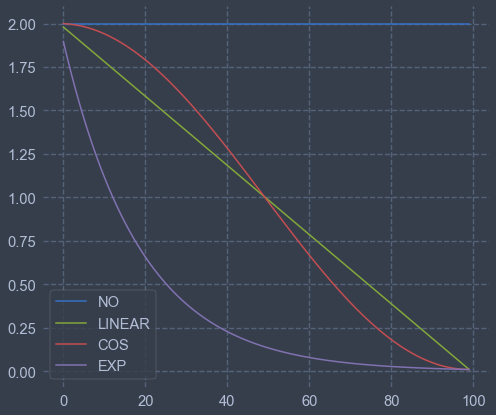

In [88]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [76]:
 #export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1., 'the interval must sum to 1'
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

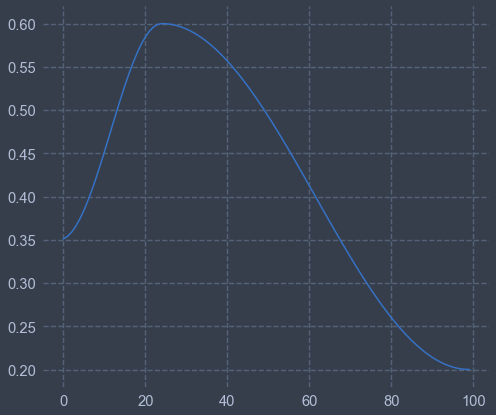

In [79]:
sched = combine_scheds([0.25, 0.75], [sched_cos(0.35, 0.6), sched_cos(0.6, 0.2)])
plt.plot(a, [sched(o) for o in p])

In [80]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [81]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [82]:
run.fit(3, learn)

train: [0.747739921875, tensor(0.7915)]
valid: [0.29852138671875, tensor(0.9137)]
train: [0.29006427734375, tensor(0.9163)]
valid: [0.2385187255859375, tensor(0.9332)]
train: [0.23708349609375, tensor(0.9324)]
valid: [0.2106822509765625, tensor(0.9401)]


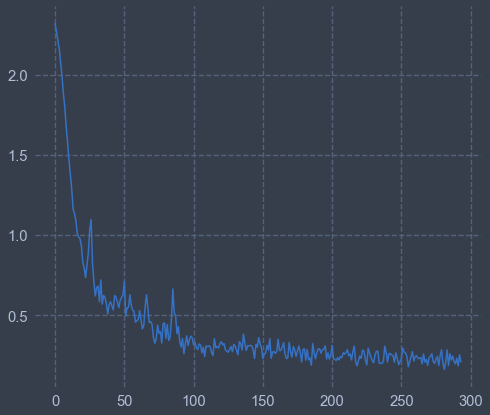

In [83]:
run.recorder.plot_loss()

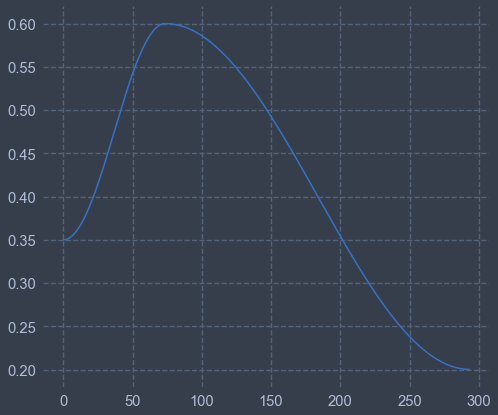

In [84]:
run.recorder.plot_lr()

In [89]:
!python notebook2script.py 03_anneal.ipynb

Converted 03_anneal.ipynb to exp\nb_03.py
